In [40]:
#Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
train_dir ='Dataset/seg_train/seg_train'
test_dir ='Dataset/seg_test/seg_test'

In [42]:
batch_size =32
image_size = (150,150)
epoch=30

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [44]:
label =train_ds.class_names
label

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

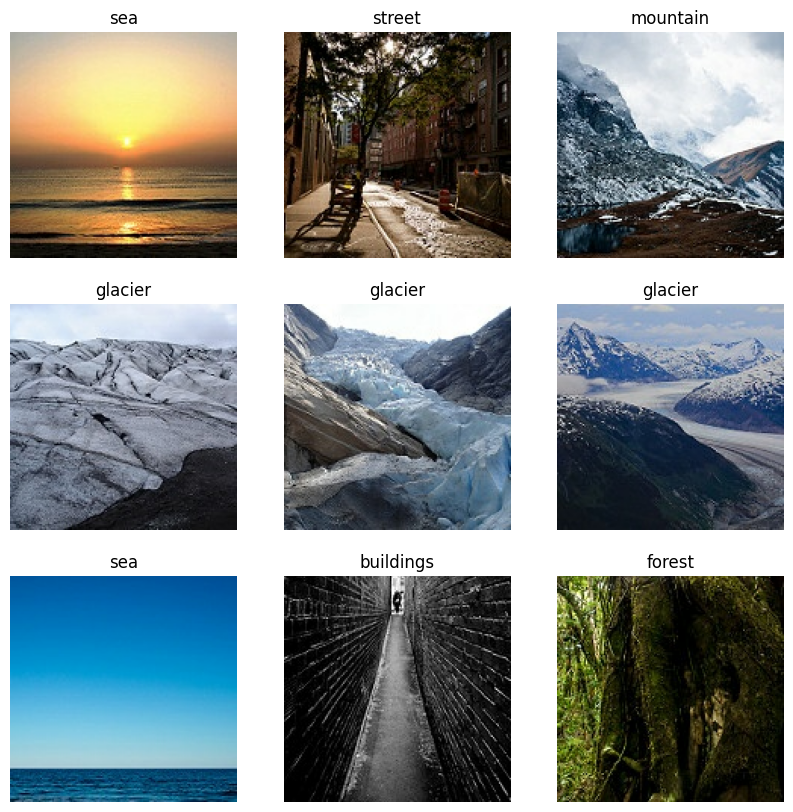

In [45]:
# Visualizing Intel Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label[labels[i]])
        plt.axis("off")

# Normalizing the dataset

In [46]:
#Define the parameters for Normalization
Datagen =ImageDataGenerator(rescale=1.0/255)

In [47]:
train_set =Datagen.flow_from_directory(train_dir, target_size=image_size,
                                                   batch_size=batch_size)
test_set =Datagen.flow_from_directory(test_dir, target_size=image_size,
                                                 batch_size=batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [48]:
#define model architecture
model =Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))

# Adding second conv layer with 128 filters and kernel size 3x3
model.add(Conv2D(128, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D((2,2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.2
model.add(Dense(512, activation ='relu'))
model.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax
model.add(Dense(6, activation='softmax'))

# instantiate adam optimizer
adam=Adam()

# Compile model
model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [49]:
filename='Models/Basemodel.hdf5'

es=EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='loss', verbose=1, min_lr = 0.000001)
chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

In [50]:
#train the network
hist =model.fit(train_set, steps_per_epoch=train_set.samples//32,epochs=epoch, validation_data=test_set,
                validation_steps=test_set.samples//32, callbacks=[chkpt, es, lr_scheduler] )

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 1.0414 - accuracy: 0.5777
Epoch 1: val_loss improved from inf to 0.78599, saving model to Models\Basemodel.hdf5
438/438 [==============================] - 86s 194ms/step - loss: 1.0414 - accuracy: 0.5777 - val_loss: 0.7860 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 2/30
435/438 [============================>.] - ETA: 0s - loss: 0.7205 - accuracy: 0.7277
Epoch 2: val_loss improved from 0.78599 to 0.63200, saving model to Models\Basemodel.hdf5
438/438 [==============================] - 9s 20ms/step - loss: 0.7196 - accuracy: 0.7282 - val_loss: 0.6320 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7960
Epoch 3: val_loss improved from 0.63200 to 0.50991, saving model to Models\Basemodel.hdf5
438/438 [==============================] - 9s 20ms/step - loss: 0.5650 - accuracy: 0.7960 - val_loss: 0.5099 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 4/3

In [54]:
df=pd.DataFrame(hist.history)
df['epochs']=hist.epoch
df

,loss,accuracy,val_loss,val_accuracy,lr,epochs
0,1.041430,0.577703,0.785991,0.694892,0.001,0
1,0.719645,0.728182,0.631998,0.774194,0.001,1
2,0.564969,0.795958,0.509911,0.817540,0.001,2
3,0.460105,0.832667,0.568688,0.795363,0.001,3
4,0.390656,0.860163,0.499106,0.832325,0.001,4
5,0.312094,0.890444,0.529218,0.823589,0.001,5
6,0.247811,0.912370,0.541242,0.825941,0.001,6
7,0.199879,0.929153,0.564677,0.843078,0.001,7


Text(0, 0.5, 'loss')

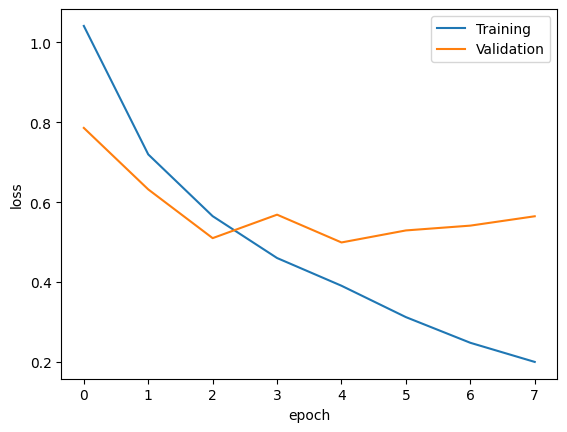

In [55]:
#visualize the model performance
import matplotlib.pyplot as plt
plt.plot(df['loss'], label ='Training')
plt.plot(df['val_loss'], label ='Validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

In [56]:
model.evaluate(test_set)

94/94 [==============================] - 1s 14ms/step - loss: 0.5665 - accuracy: 0.8423


[0.566480278968811, 0.8423333168029785]

# Model with DATA AUGUMENTATION

# Data Augumentation

In [16]:
#Define the parameters for data augumentation
train_datagen =ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, vertical_flip=True, shear_range=0.2, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [17]:
train_generator =train_datagen.flow_from_directory(train_dir, target_size=(150,150),
                                                   batch_size=batch_size)
test_generator =test_datagen.flow_from_directory(test_dir, target_size=(150,150),
                                                 batch_size=batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [57]:
#define model architecture
model1 =Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3
model1.add(Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model1.add(MaxPooling2D((2,2)))

# Adding second conv layer with 128 filters and kernel size 3x3
model1.add(Conv2D(128, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model1.add(MaxPooling2D((2,2)))

model1.add(Conv2D(128, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model1.add(MaxPooling2D((2,2)))

model1.add(Conv2D(256, (3,3), activation='relu'))
# Adding max pooling to reduce the size of output of second conv layer
model1.add(MaxPooling2D((2,2)))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.2
model1.add(Dense(512, activation ='relu'))
model1.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax
model1.add(Dense(6, activation='softmax'))

# instantiate adam optimizer
adam=Adam()

# Compile model
model1.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [58]:
filename='Models/dataaugBasemodel.hdf5'

es=EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

chkpt2=ModelCheckpoint(filename, verbose=1, save_best_only =True)

In [59]:
#train the network
hist1 =model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
438/438 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.7666
Epoch 1: val_loss improved from inf to 0.49467, saving model to Models\dataaugBasemodel.hdf5
438/438 [==============================] - 36s 82ms/step - loss: 0.6238 - accuracy: 0.7666 - val_loss: 0.4947 - val_accuracy: 0.8155
Epoch 2/30
438/438 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.8135
Epoch 2: val_loss improved from 0.49467 to 0.44437, saving model to Models\dataaugBasemodel.hdf5
438/438 [==============================] - 36s 82ms/step - loss: 0.5122 - accuracy: 0.8135 - val_loss: 0.4444 - val_accuracy: 0.8340
Epoch 3/30
438/438 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8287
Epoch 3: val_loss did not improve from 0.44437
438/438 [==============================] - 35s 81ms/step - loss: 0.4668 - accuracy: 0.8287 - val_loss: 0.4907 - val_accuracy: 0.8350
Epoch 4/30
438/438 [==============================] - ETA: 0s - loss: 0.4478

In [60]:
df1=pd.DataFrame(hist1.history)
df1['epochs']=hist1.epoch
df1

,loss,accuracy,val_loss,val_accuracy,epochs
0,0.623794,0.766605,0.494674,0.815524,0
1,0.512186,0.813527,0.444368,0.834005,1
2,0.466826,0.828667,0.490725,0.835013,2
3,0.447843,0.841237,0.484028,0.822581,3
4,0.417699,0.847807,0.478597,0.831653,4


Text(0, 0.5, 'loss')

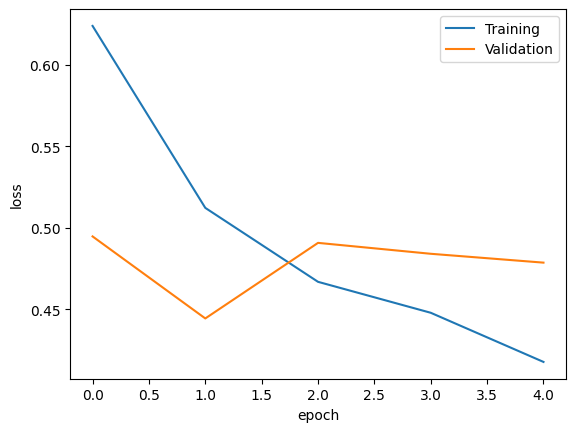

In [61]:
#visualize the model performance
import matplotlib.pyplot as plt
plt.plot(df1['loss'], label ='Training')
plt.plot(df1['val_loss'], label ='Validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

In [62]:
model1.evaluate(test_generator)

94/94 [==============================] - 2s 15ms/step - loss: 1.7880 - accuracy: 0.1847


[1.7879934310913086, 0.18466666340827942]

# VGG 16

In [63]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (150,150,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [64]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [65]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.5
new_model.add(Dense(512, activation ='relu'))
new_model.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax
new_model.add(Dense(6, activation='softmax'))

adam=Adam()

# Compile model
new_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 18,912,582
Trainable params: 4,197,894
Non-trainable params: 14,714,688
_________________________________________________________________


In [66]:
filename='Models/Vgg16model.hdf5'

es=EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='loss', verbose=1, min_lr = 0.000001)

In [67]:
#train the network
hist3 =new_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.7650
Epoch 1: val_loss improved from inf to 0.45132, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 38s 84ms/step - loss: 0.6252 - accuracy: 0.7650 - val_loss: 0.4513 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8199
Epoch 2: val_loss improved from 0.45132 to 0.39492, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 36s 83ms/step - loss: 0.4824 - accuracy: 0.8199 - val_loss: 0.3949 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8343
Epoch 3: val_loss improved from 0.39492 to 0.38609, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 36s 83ms/step - loss: 0.4371 - accuracy: 0.8343 - val_loss: 0.3861 - val_accuracy: 0.8597 - lr: 0.0010
Epoch

In [73]:
df2=pd.DataFrame(hist3.history)
df2['epochs']=hist3.epoch
df2

,loss,accuracy,val_loss,val_accuracy,lr,epochs
0,0.625200,0.764999,0.451325,0.834667,0.001,0
1,0.482392,0.819866,0.394923,0.853333,0.001,1
2,0.437116,0.834331,0.386088,0.859667,0.001,2
3,0.411133,0.847727,0.365835,0.862667,0.001,3
4,0.401938,0.849366,0.370100,0.862333,0.001,4
5,0.385353,0.854924,0.395112,0.852000,0.001,5
6,0.377108,0.857418,0.361012,0.869000,0.001,6
7,0.353714,0.866253,0.356256,0.866000,0.001,7
8,0.354242,0.863118,0.351569,0.860000,0.001,8
9,0.343878,0.868249,0.352815,0.865000,0.001,9


Text(0, 0.5, 'loss')

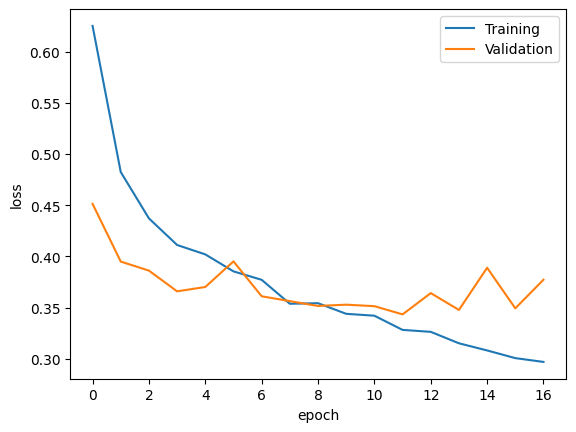

In [74]:
#visualize the model performance
import matplotlib.pyplot as plt
plt.plot(df2['loss'], label ='Training')
plt.plot(df2['val_loss'], label ='Validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

In [75]:
new_model.evaluate(test_generator)

94/94 [==============================] - 2s 22ms/step - loss: 0.3772 - accuracy: 0.8603


[0.3771856725215912, 0.8603333234786987]

# RESNET 50

In [81]:
from keras.applications import ResNet50 

Resnet_model = ResNet50 (weights='imagenet', include_top = False, input_shape = (150,150,3))
Resnet_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block1_out (Activation)  (None, 5, 5, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

In [83]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in Resnet_model.layers:
    layer.trainable = False

In [84]:
resnet50_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
resnet50_model.add(Resnet_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
resnet50_model.add(Flatten())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.5
resnet50_model.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax
resnet50_model.add(Dense(6, activation='softmax'))

adam=Adam()

# Compile model
resnet50_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
resnet50_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_8 (Dropout)         (None, 51200)             0         
                                                                 
 dense_14 (Dense)            (None, 6)                 307206    
                                                                 
Total params: 23,894,918
Trainable params: 307,206
Non-trainable params: 23,587,712
_________________________________________________________________


In [85]:
filename='Models/Resnetmodel.hdf5'

es=EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='loss', verbose=1, min_lr = 0.000001)

In [86]:
#train the network
Resnet50 =resnet50_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.4609 - accuracy: 0.4218
Epoch 1: val_loss improved from inf to 1.19174, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 40s 87ms/step - loss: 1.4609 - accuracy: 0.4218 - val_loss: 1.1917 - val_accuracy: 0.5087 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.2527 - accuracy: 0.5050
Epoch 2: val_loss improved from 1.19174 to 1.16617, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 37s 85ms/step - loss: 1.2527 - accuracy: 0.5050 - val_loss: 1.1662 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.1745 - accuracy: 0.5405
Epoch 3: val_loss improved from 1.16617 to 1.01887, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 37s 84ms/step - loss: 1.1745 - accuracy: 0.5405 - val_loss: 1.0189 - val_accuracy: 0.5810 - lr: 0.0010
Ep

In [87]:
df3=pd.DataFrame(Resnet50.history)
df3['epochs']=Resnet50.epoch
df3

,loss,accuracy,val_loss,val_accuracy,lr,epochs
0,1.460904,0.421833,1.191739,0.508667,0.001,0
1,1.252741,0.504988,1.166171,0.548333,0.001,1
2,1.174491,0.540544,1.018870,0.581000,0.001,2
3,1.167834,0.539404,1.141414,0.557333,0.001,3
4,1.202920,0.536697,0.954702,0.614667,0.001,4
5,1.175101,0.551732,1.170967,0.543667,0.001,5
6,1.134623,0.560710,1.309280,0.518333,0.001,6
7,1.153935,0.557004,1.158697,0.556667,0.001,7
8,1.092425,0.575032,0.968705,0.624667,0.001,8
9,1.122877,0.571826,1.043178,0.584333,0.001,9


Text(0, 0.5, 'loss')

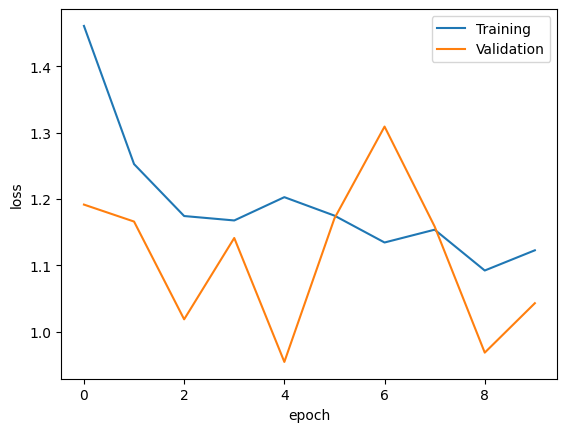

In [88]:
#visualize the model performance
import matplotlib.pyplot as plt
plt.plot(df3['loss'], label ='Training')
plt.plot(df3['val_loss'], label ='Validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

In [89]:
resnet50_model.evaluate(test_generator)

94/94 [==============================] - 2s 21ms/step - loss: 1.0431 - accuracy: 0.5843


[1.0431262254714966, 0.5843333601951599]

# Inception V3

In [91]:
from keras.applications import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top = False, input_shape = (150,150,3))
inception_model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_20[0][0]']              
 alization)                                                                                       
                      

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 64)  192         ['conv2d_27[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
          

 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_54 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_64 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 7, 7, 160)   480         ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_54 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_71

 batch_normalization_65 (BatchN  (None, 7, 7, 192)   576         ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_81 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_81[0][0]']              
 ormalizat

 conv2d_90 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 7, 7, 192)   576         ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 batch_normalization_76 (BatchN  (None, 3, 3, 320)   960         ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 3, 3, 192)   576         ['conv2d_113[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [92]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in inception_model.layers:
    layer.trainable = False

In [93]:
inceptionv3_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
inceptionv3_model.add(inception_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
inceptionv3_model.add(Flatten())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.5
inceptionv3_model.add(Dropout(0.2))

# Adding the output layer with 10 neurons and activation functions as softmax
inceptionv3_model.add(Dense(6, activation='softmax'))

adam=Adam()

# Compile model
inceptionv3_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
inceptionv3_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_9 (Dropout)         (None, 18432)             0         
                                                                 
 dense_15 (Dense)            (None, 6)                 110598    
                                                                 
Total params: 21,913,382
Trainable params: 110,598
Non-trainable params: 21,802,784
_________________________________________________________________


In [96]:
filename='Models/inceptionmodel.hdf5'

es=EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='loss', verbose=1, min_lr = 0.000001)

In [97]:
#train the network
inception =inceptionv3_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.3474 - accuracy: 0.7823
Epoch 1: val_loss improved from inf to 1.10184, saving model to Models\inceptionmodel.hdf5
439/439 [==============================] - 39s 85ms/step - loss: 1.3474 - accuracy: 0.7823 - val_loss: 1.1018 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.3328 - accuracy: 0.8190
Epoch 2: val_loss improved from 1.10184 to 0.95684, saving model to Models\inceptionmodel.hdf5
439/439 [==============================] - 37s 84ms/step - loss: 1.3328 - accuracy: 0.8190 - val_loss: 0.9568 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.3494 - accuracy: 0.8356
Epoch 3: val_loss did not improve from 0.95684
439/439 [==============================] - 36s 81ms/step - loss: 1.3494 - accuracy: 0.8356 - val_loss: 1.0086 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 4/30
439/439 [=====================

In [99]:
df4=pd.DataFrame(inception.history)
df4['epochs']=inception.epoch
df4

,loss,accuracy,val_loss,val_accuracy,lr,epochs
0,1.347414,0.782314,1.101839,0.838000,0.001,0
1,1.332810,0.819011,0.956840,0.872333,0.001,1
2,1.349373,0.835613,1.008621,0.864333,0.001,2
3,1.339227,0.838535,1.048519,0.877000,0.001,3
4,1.291729,0.848938,1.090408,0.876667,0.001,4
5,1.397622,0.845447,1.287231,0.865333,0.001,5
6,1.457793,0.845376,1.462734,0.857000,0.001,6


Text(0, 0.5, 'loss')

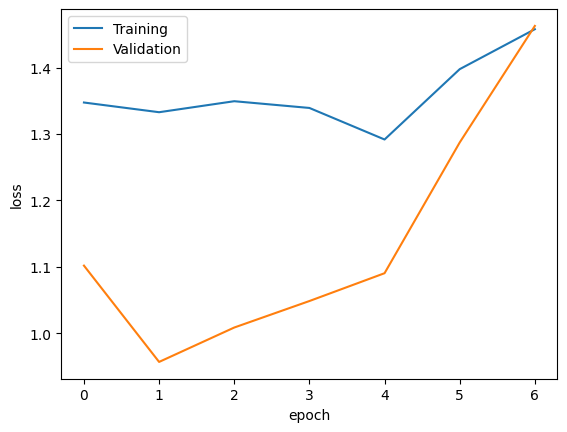

In [100]:
#visualize the model performance
import matplotlib.pyplot as plt
plt.plot(df4['loss'], label ='Training')
plt.plot(df4['val_loss'], label ='Validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

In [101]:
inceptionv3_model.evaluate(test_generator)

94/94 [==============================] - 2s 17ms/step - loss: 1.4627 - accuracy: 0.8570


[1.4627074003219604, 0.8569999933242798]